In [4]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import time
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import shap


In [5]:
df = pd.read_csv('SAdata_allMeasures.csv')

print(df.isnull().sum())

y = df['Y']
X = df.drop(columns=['Y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
df.head()

age                      0
gender                   0
yearDriving              0
drivingFrequency         0
temp_length              0
temp_decisiontime        0
temp_decision_made       0
temp_correct_decision    0
temp_danger              0
temp_difficulty          0
CarPlacedLeft            0
CarPlacedRight           0
numS                     0
sAmpMean                 0
sAmpStd                  0
sAmpMax                  0
numF                     0
fMean                    0
fStd                     0
fMax                     0
backMirror               0
leftMirror               0
rightMirror              0
road                     0
sky                      0
pupilChange              0
pupilMean                0
pupilStd                 0
Y                        0
dtype: int64
(843, 28)


,age,gender,yearDriving,drivingFrequency,temp_length,temp_decisiontime,temp_decision_made,temp_correct_decision,temp_danger,temp_difficulty,...,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,Y
0,26,1,20,1,12,4.80219,4,2,20,89,...,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,26,1,20,1,6,4.91667,1,2,10,99,...,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,26,1,20,1,1,2.21716,2,2,99,99,...,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,26,1,20,1,3,2.63056,1,2,9,79,...,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,26,1,20,1,9,2.42632,1,2,9,96,...,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333


## Preprocessing

Since many features have different 

In [6]:
from sklearn.preprocessing import StandardScaler

#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## Baseline LR

In [7]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

linear_predictions = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_predictions)
print("Linear Regression Mean Squared Error:", linear_mse)

linear_r2 = r2_score(y_test, linear_predictions)
print("Linear Regression R-squared:", linear_r2)

Linear Regression Mean Squared Error: 0.013088468386775068
Linear Regression R-squared: 0.2266474649334408


## XGB

In [8]:
#https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation
#https://xgboost.readthedocs.io/en/latest/python/examples/cross_validation.html

dtrain = xgb.DMatrix(X, label=y) 
#https://stackoverflow.com/questions/70127049/what-is-the-use-of-dmatrix

params = {
    "max_depth": 2, 
    "eta": 0.1,
    "objective": "reg:squarederror",
    "verbosity": 0
}

start_time_gbm = time.time()

results = xgb.cv(
    params,
    dtrain,
    num_boost_round=100,
    nfold=5,
    metrics=['rmse', 'mae'],
    early_stopping_rounds=10,
    callbacks=[xgb.callback.EvaluationMonitor()], #https://xgboosting.com/how-to-use-xgboost-evaluationmonitor-callback/
    seed=42,
    verbose_eval=False
)

stop_time_gbm = time.time()

gbm_train_time = stop_time_gbm - start_time_gbm

gbm_rsme = results['test-rmse-mean']
gbm_mae = results['test-mae-mean']

gbm_rsme_train = results['train-rmse-mean']
gbm_mae_train = results['train-mae-mean']




[0]	train-rmse:0.13269	train-mae:0.10864	test-rmse:0.13291	test-mae:0.10901
[1]	train-rmse:0.13037	train-mae:0.10658	test-rmse:0.13090	test-mae:0.10705
[2]	train-rmse:0.12842	train-mae:0.10481	test-rmse:0.12908	test-mae:0.10537
[3]	train-rmse:0.12659	train-mae:0.10314	test-rmse:0.12762	test-mae:0.10404
[4]	train-rmse:0.12512	train-mae:0.10179	test-rmse:0.12636	test-mae:0.10276
[5]	train-rmse:0.12373	train-mae:0.10047	test-rmse:0.12521	test-mae:0.10163
[6]	train-rmse:0.12248	train-mae:0.09927	test-rmse:0.12398	test-mae:0.10049
[7]	train-rmse:0.12142	train-mae:0.09823	test-rmse:0.12303	test-mae:0.09963
[8]	train-rmse:0.12046	train-mae:0.09728	test-rmse:0.12224	test-mae:0.09888
[9]	train-rmse:0.11951	train-mae:0.09635	test-rmse:0.12166	test-mae:0.09829
[10]	train-rmse:0.11866	train-mae:0.09550	test-rmse:0.12098	test-mae:0.09760
[11]	train-rmse:0.11782	train-mae:0.09473	test-rmse:0.12041	test-mae:0.09707
[12]	train-rmse:0.11703	train-mae:0.09401	test-rmse:0.11969	test-mae:0.09636
[13]	trai

# LGB

In [ ]:
params = {
    'objective': 'regression',
    'num_leaves': 20,              # Smaller for small dataset
    'learning_rate': 0.1,          # Slightly higher
    'min_data_in_leaf': 5,         # Smaller for small dataset
    'bagging_freq': 5,
    'lambda_l1': 0.1,              # Some regularization
    'metric': ['rmse', 'mae'],
    'verbose': -1,
}

train_data = lgb.Dataset(X_train, label=y_train)

#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.htmlxw
#https://stackoverflow.com/questions/49774825/how-to-use-lightgbm-cv-for-regression

# Store evaluation history
evals_result = {}
record_eval = lgb.record_evaluation(evals_result)
early_stopping_callback = lgb.early_stopping(5, first_metric_only=False, verbose=False)

start_time_lgb = time.time()
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=100,
    nfold=10,
    callbacks=[record_eval, early_stopping_callback],
    stratified=False, 
    eval_train_metric=True, 
    seed=42
)
stop_time_lgb = time.time()


############    Results    ############
lgb_train_time = stop_time_lgb - start_time_lgb

lgb_train_rmse = evals_result['train']['rmse-mean']
lgb_train_mae = evals_result['train']['l1-mean']

lgb_valid_rmse = evals_result['valid']['rmse-mean']
lgb_valid_mae = evals_result['valid']['l1-mean']

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

## LGB Distributed

In [10]:
params = {
        'objective': 'regression',
        'metric': ['rmse', 'mae'],
        'num_leaves': 20,           
        'learning_rate': 0.1,     
        'min_data_in_leaf': 5,    
        'bagging_freq': 5,
        'verbose': -1,       
        # Distributed settings
        'num_threads': 8,
        'tree_learner': 'feature', 
        'force_row_wise': True
    }



# Store evaluation history
evals_result_distributed = {}
record_eval = lgb.record_evaluation(evals_result)
early_stopping_callback = lgb.early_stopping(5, first_metric_only=False, verbose=False)



start_time_lgb = time.time()

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=100,
    nfold=10,
    callbacks=[record_eval, early_stopping_callback],
    stratified=False, 
    eval_train_metric=True, 
    seed=42
)

stop_time_lgb = time.time()

print(evals_result)

############    Results    ############
lgb_train_time = stop_time_lgb - start_time_lgb

lgb_train_rmse_disributed = evals_result['train']['rmse-mean']
lgb_train_mae_disributed = evals_result['train']['l1-mean']

lgb_valid_rmse_disributed = evals_result['valid']['rmse-mean']
lgb_valid_mae_disributed = evals_result['valid']['l1-mean']


{'train': OrderedDict({'rmse-mean': [0.1312365569500538, 0.12636338767644512, 0.12208244277586848, 0.11816580120667979, 0.11456946718547205, 0.11127623359286642, 0.10832052197110453, 0.10558277119236814, 0.10309592743713761, 0.10077272571448662, 0.09854040311888537, 0.09651085015533048, 0.09463367580222458, 0.09278016228387627, 0.09104309298840803, 0.08937552632461339, 0.08772377798285479, 0.0860830799891302, 0.08461303344318971, 0.08310039707431233, 0.08169631616028193, 0.08029698113273397, 0.07896059405360353, 0.07768888931751702, 0.07645686242129464, 0.07525124610518372], 'rmse-stdv': [0.0011465918854940728, 0.0010759974487911672, 0.001047775263945787, 0.001169859556246872, 0.0010011210680266865, 0.0009775913668692848, 0.0008682739242671787, 0.0009049364080875395, 0.0008572608074648955, 0.0008311088940553326, 0.0008439966178129985, 0.0008912249804684407, 0.000925090359459679, 0.0008542609181597745, 0.0007948190620165323, 0.0007974899895332437, 0.0007939740853474943, 0.00086347430121

## REPORT

In [ ]:
#Code in this cell is mostly genareted with the help of an LLM.
def plot_split_metrics(metrics_dict):
    """
    Plot training and validation metrics in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Color palette - same base color with different shades for each model
    colors = {
        'LightGBM': {
            'rmse': '#1a53ff',  # Darker blue
            'mae': '#668cff'    # Lighter blue
        },
        'XGBoost': {
            'rmse': '#ff1a1a',  # Darker red
            'mae': '#ff6666'    # Lighter red
        },
        'Distributed LightGBM': {
            'rmse': '#00cc00',  # Darker green
            'mae': '#66ff66'    # Lighter green
        }
    }
    
    # Training metrics plot
    for model_name, metrics in metrics_dict.items():
        color_dict = colors[model_name]
        
        # Plot training metrics
        ax1.plot(metrics['train_rmse'], label=f'{model_name} RMSE', 
                color=color_dict['rmse'], linewidth=2)
        ax1.plot(metrics['train_mae'], label=f'{model_name} MAE', 
                color=color_dict['mae'], linewidth=2)
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel('Iterations', fontsize=12)
    ax1.set_ylabel('Error', fontsize=12)
    ax1.set_title('Training Metrics', fontsize=14, pad=15)
    ax1.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    ax1.set_facecolor('#f8f9fa')
    
    # Validation metrics plot
    for model_name, metrics in metrics_dict.items():
        color_dict = colors[model_name]
        
        # Plot validation metrics
        ax2.plot(metrics['valid_rmse'], label=f'{model_name} RMSE', 
                color=color_dict['rmse'], linewidth=2)
        ax2.plot(metrics['valid_mae'], label=f'{model_name} MAE', 
                color=color_dict['mae'], linewidth=2)
    
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel('Iterations', fontsize=12)
    ax2.set_ylabel('Error', fontsize=12)
    ax2.set_title('Validation Metrics', fontsize=14, pad=15)
    ax2.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    ax2.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    return fig

def print_final_values(metrics_dict):
    for model_name, metrics in metrics_dict.items():
        print(f"\n{model_name}:")
        print(f"Valid RMSE: {metrics['valid_rmse'].iloc[-1]:.4f}")
        print(f"Valid MAE: {metrics['valid_mae'].iloc[-1]:.4f}")


XGBoost:
Valid RMSE: 0.1120
Valid MAE: 0.0885

LightGBM:
Valid RMSE: 0.1150
Valid MAE: 0.0895

Distributed LightGBM:
Valid RMSE: 0.1158
Valid MAE: 0.0902


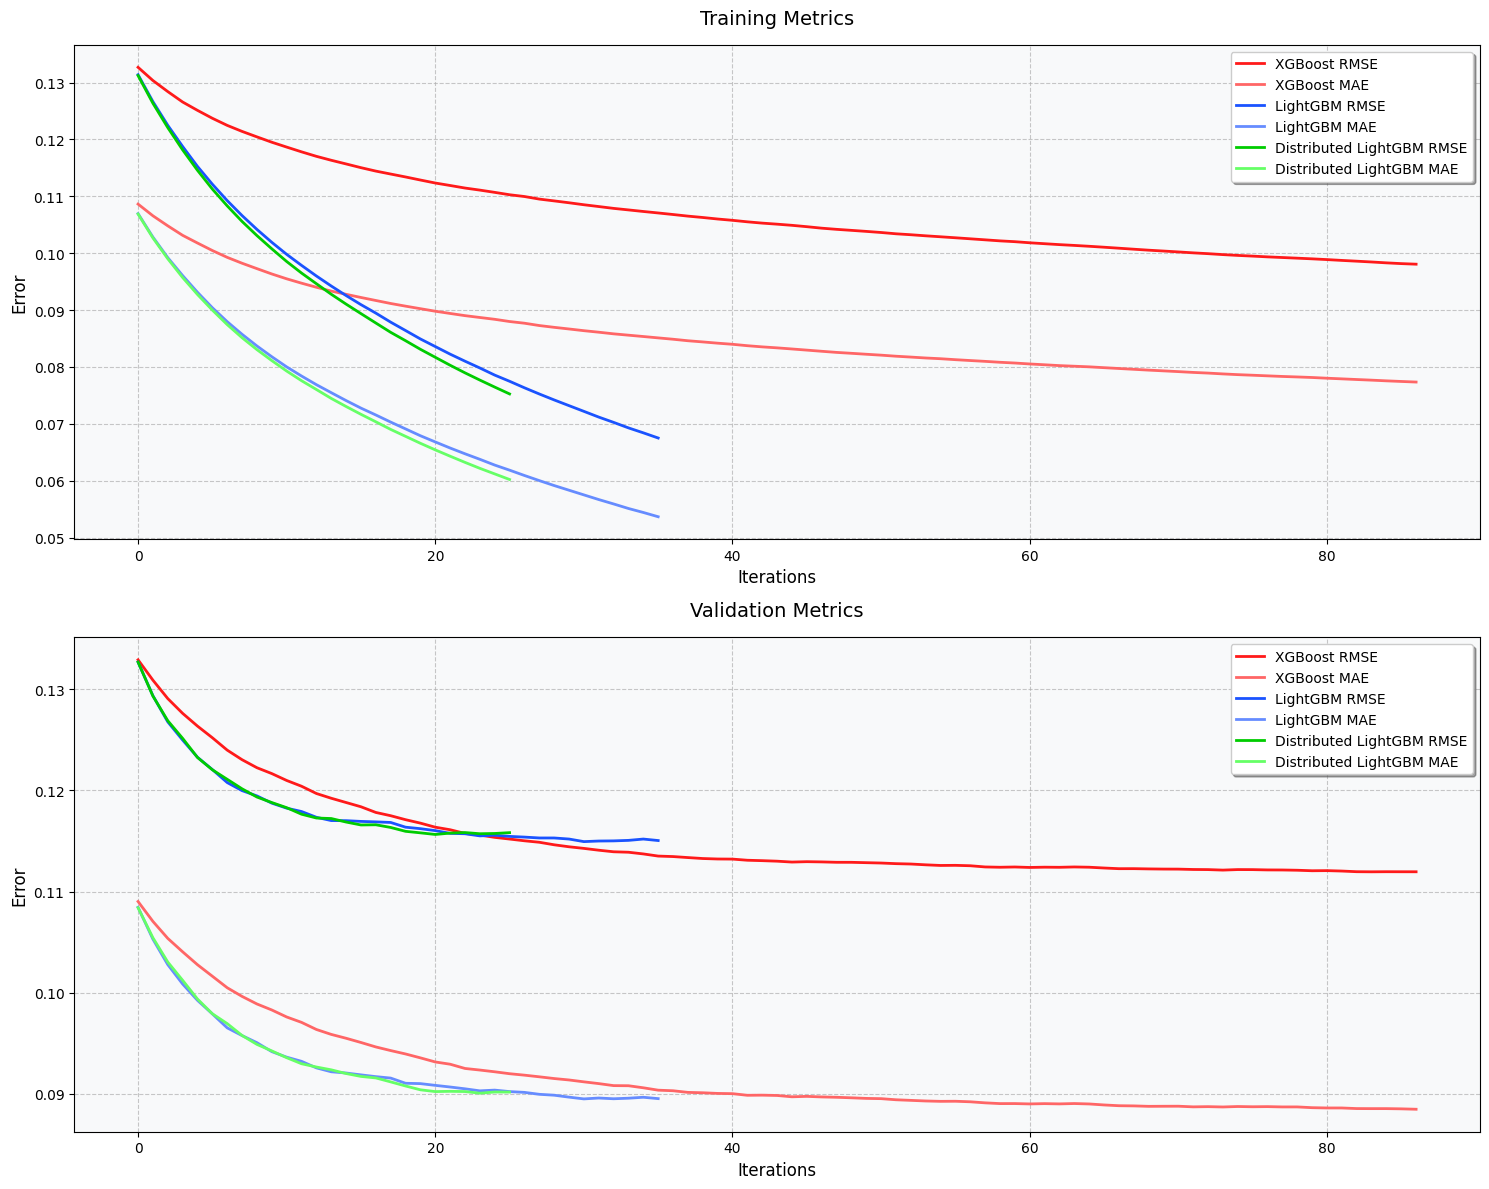

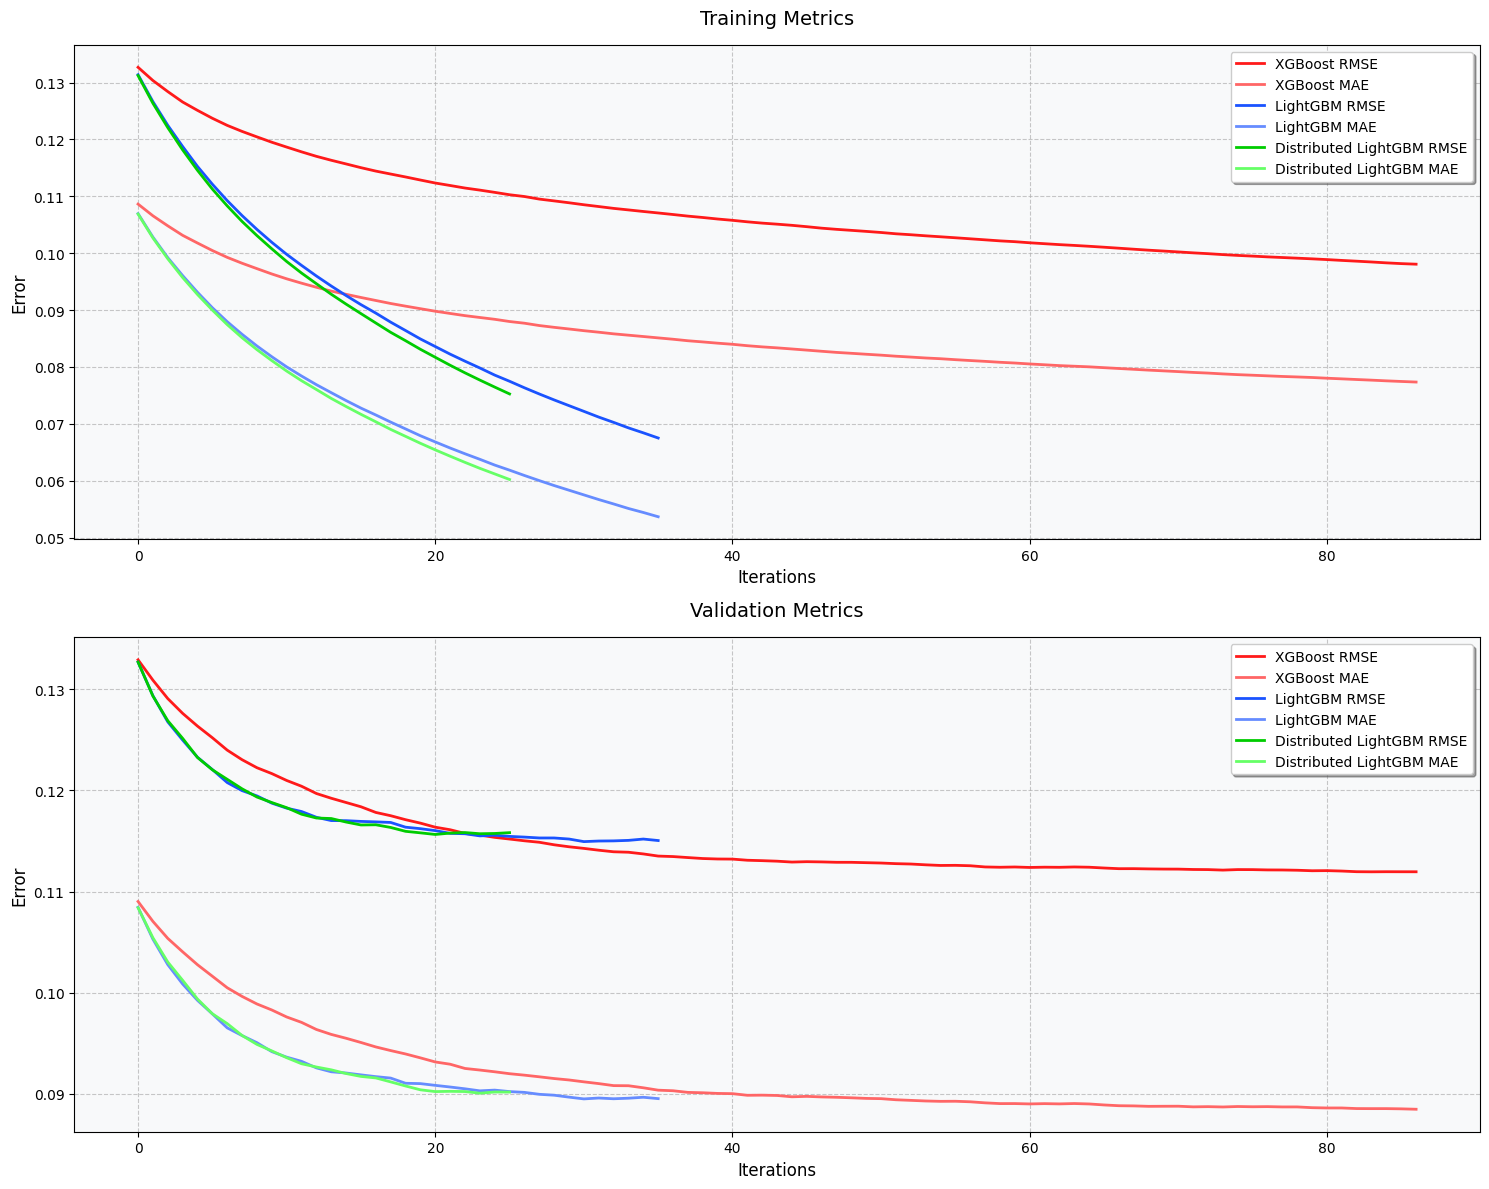

In [12]:
# GBM provides different data types for metrics
metrics_dict = {
    'XGBoost': {
        'train_rmse': pd.Series(gbm_rsme_train),
        'train_mae': pd.Series(gbm_mae_train),
        'valid_rmse': pd.Series(gbm_rsme),
        'valid_mae': pd.Series(gbm_mae)
    },
    'LightGBM': {
        'train_rmse': pd.Series(lgb_train_rmse),
        'train_mae': pd.Series(lgb_train_mae),
        'valid_rmse': pd.Series(lgb_valid_rmse),
        'valid_mae': pd.Series(lgb_valid_mae)
    },
    'Distributed LightGBM': {
        'train_rmse': pd.Series(lgb_train_rmse_disributed),
        'train_mae': pd.Series(lgb_train_mae_disributed),
        'valid_rmse': pd.Series(lgb_valid_rmse_disributed),
        'valid_mae': pd.Series(lgb_valid_mae_disributed)
    }
}

print_final_values(metrics_dict)
plot_split_metrics(metrics_dict)

## SHAP

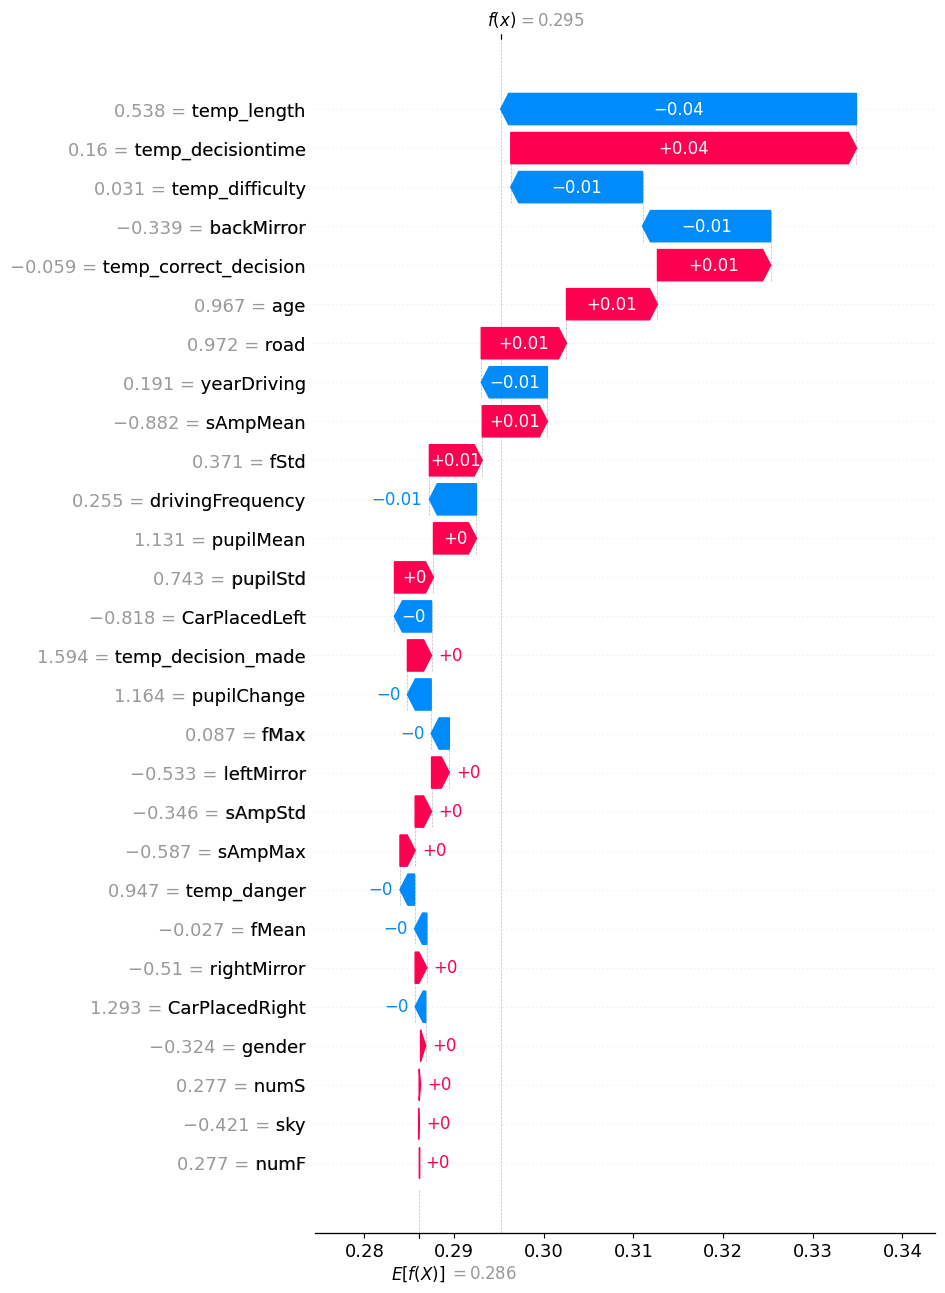

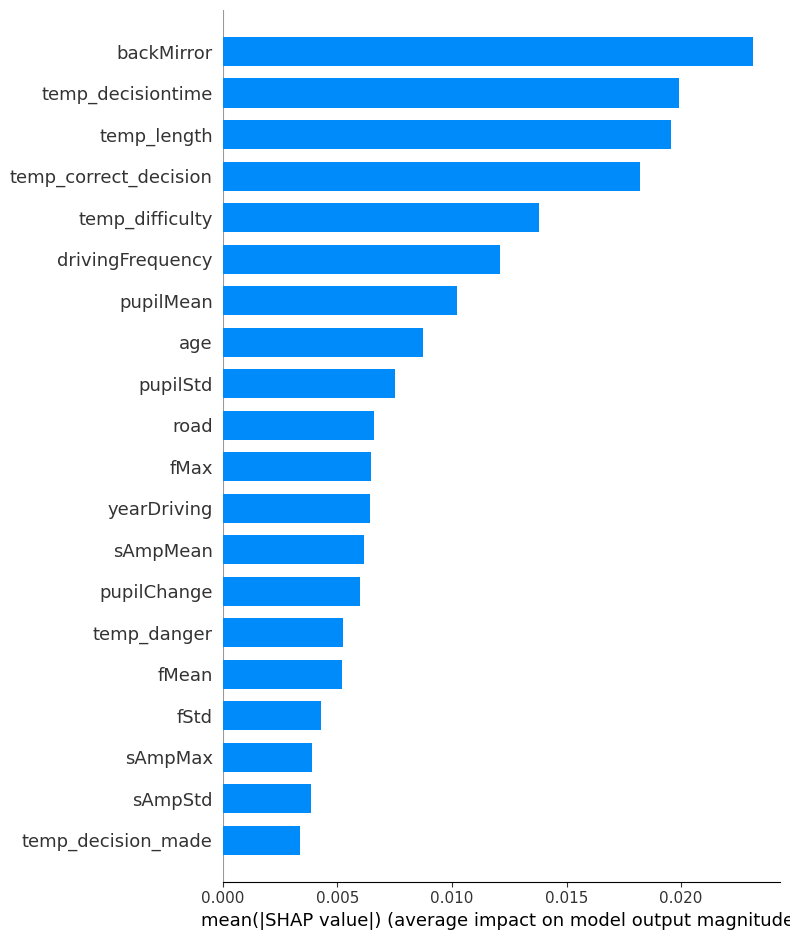

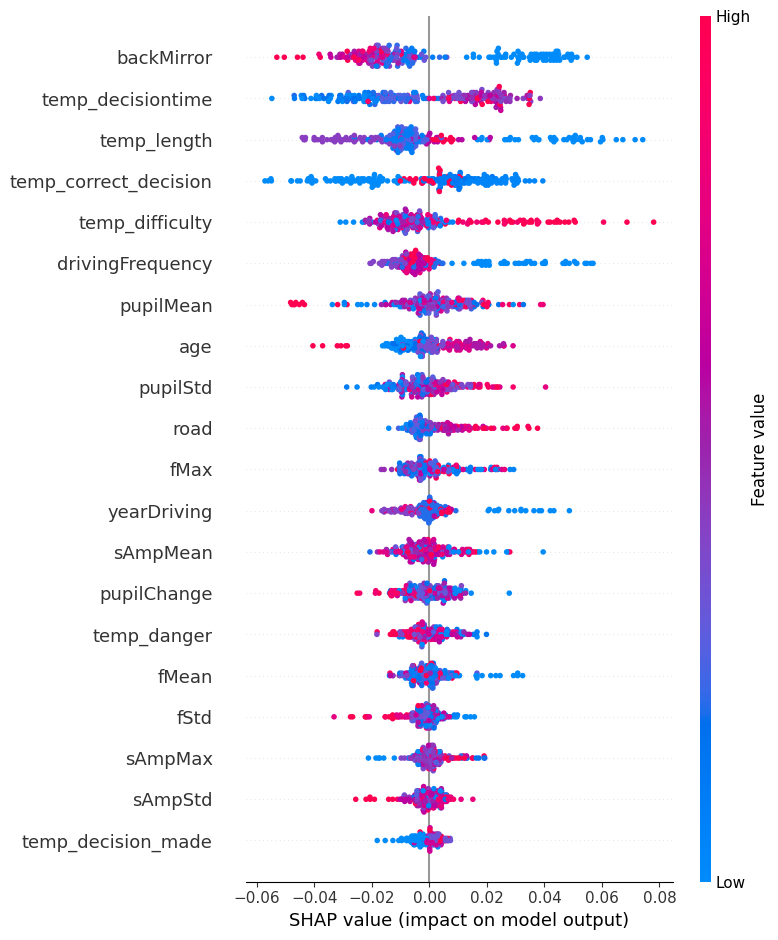

In [15]:
#SHAP Analysis
import shap

shap.initjs()

explainer = shap.TreeExplainer(lgb.LGBMRegressor().fit(X_train, y_train))
shap_values = explainer.shap_values(X_test)
X_test_df = pd.DataFrame(X_test, columns=df.drop(columns=['Y']).columns) # Convert to DataFrame to display because scalar turns it into a numpy array
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_df.iloc[0]), max_display=30)
shap.plots.force(explainer.expected_value, shap_values[0], X_test_df.iloc[0])
shap.plots.force(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100])

shap.summary_plot(shap_values, X_test_df, plot_type='bar')
shap.summary_plot(shap_values, X_test_df)


In [ ]:
X_test_df = pd.DataFrame(X_test, columns=df.drop(columns=['Y']).columns) # Convert to DataFrame to use iloc
shap.plots.force(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100])
#export the plot
shap.save_html('shap_plot.html', shap.force_plot(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100]))

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100], matplotlib=True, show=False)
plt.savefig('shap_force_plot_multi.png', bbox_inches='tight', dpi=300)
plt.close()
